# Example 1b: Waveform alignment

In this example we align waveforms, which is a pre-requisite to measure relative amplitudes. Aligning the waveforms also includes finding filter optimal filter passbands for each seismic station and discarding data that is too noisy for analysis.

This notebook relies on the data previously created in the Example 1a.

Let us first import the modules we will need for this notebook and change into the `muji/` directory. Let us then remember which ones were the reference MTs.

In [1]:
from IPython.display import Image, display # trick to show files in notebook
from relmt import io, main, core
from pathlib import Path
import shutil

# Change directory
%cd muji

/projects/restricted/relMT/relmt/src/relMT/examples/muji


In [2]:
# Show the reference MT file
! head data/reference_mts.txt

#Number            nn            ee            dd            ne            nd            ed
# (int)          (Nm)          (Nm)          (Nm)          (Nm)           (Nm)         (Nm)
   7508 -3.105000e+15  3.280000e+15 -1.750000e+14  3.600000e+15  1.395000e+15 -7.130000e+14
   7640 -3.368000e+16  6.400000e+16 -3.032000e+16  7.018000e+16  7.426000e+16  1.873000e+16


## Screening the not-aligned data

We will start by screening the data using `relmt plot-alignment`. It provides a powerful visualisation of the seimic traces. As we begin with the not-yet-aligned traces, we will need to deactivate a few features.

For example, to look at the *P* wave train of station *EP02*, we need to parse the file waveform array file `muji/data/EP02_P-wvarr.npy`. We here want to sort the events by magnitude, do not want to compute the cross-correlation matrix for now (which can be computationally expensive for large *S*-wave datasets), and highlight the reference events *7508* and *7640*. On a command line, you can execute this command to get an interactive window:

```
relmt plot-alignment --sort magnitude --highlight 7508 7640 --cc none data/EP02_P-wvarr.npy
```

For this notebook, we write into a temporary file that we can display using the `-s` option.

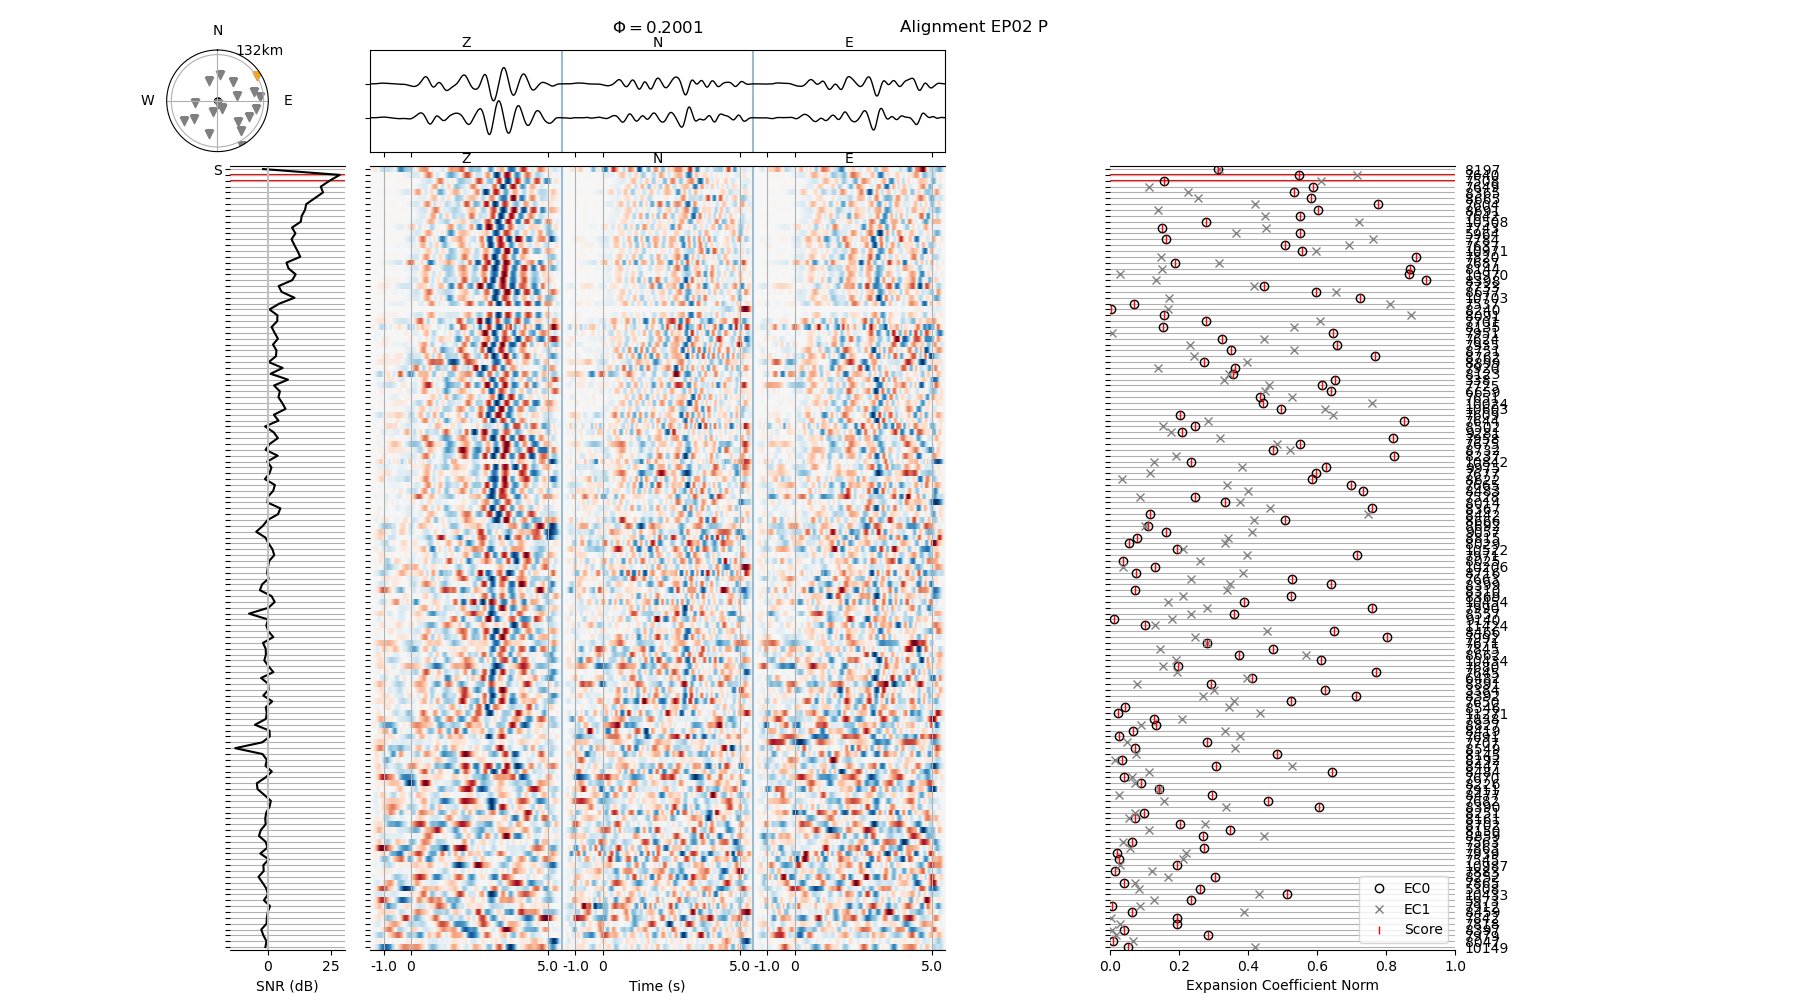

In [3]:
! relmt plot-alignment --sort magnitude --cc none --highlight 7508 7640  -s tmp.png data/EP02_P-wvarr.npy
display(Image(filename='tmp.png'))
! rm tmp.png


The center panel shows the *waveform matrix*. The three components (*Z* *N* *E*) are concatenated into a single trace. Only the time window between `phase_start` and `phase_end` plus the taper is shown and annotated at the bottom. The waveforms are filtered between the `highpass` and `lowpass` frequencies defined in the header file (here `data/EP02_P-hdr.yaml`). We see how the SNR (left panel) becomes lower with decreasing magnitude toward the bottom of the figure and how the waveforms are similar, but not yet well aligned. The original arrival time pick is located at time *0*. Some traces with a rather poor SNR ($\le$ 0 dB) do not show any signal at all.

The right-hand panel shows the *expansion coefficient norm* of each trace, a measure that becomes relevant later. The top center panel shows the first two principal components of the waveform matrix. The aim of the alignment procedure is to project as much energy as possible onto the first principal component, the *principal seismogram*.



### Change parameters of a single waveform
The signal to noise ratio depends on the time window designated as "signal" (controlled by the header parameters `phase_start` and `phase_end`) and the filter passband (controlled by `highpass` and `lowpass`). Let us change the parameters and observe the effect on the appearance of the waveform and the SNR.

Feel free to modify the header values as you please. In practice, we would edit the header file using a text editor and plot from the command line using the `relmt plot-alignment` method we used above.

Header file is:  data/EP02_P-hdr.yaml
Old header values:
phase_start: -1.0
phase_end: 5.0
highpass: 0.5
lowpass: 2.0
New header values:
phase_start: 0.0
phase_end: 3.0
highpass: 1.0
lowpass: 10.0


Figure drawn
Old header restored.


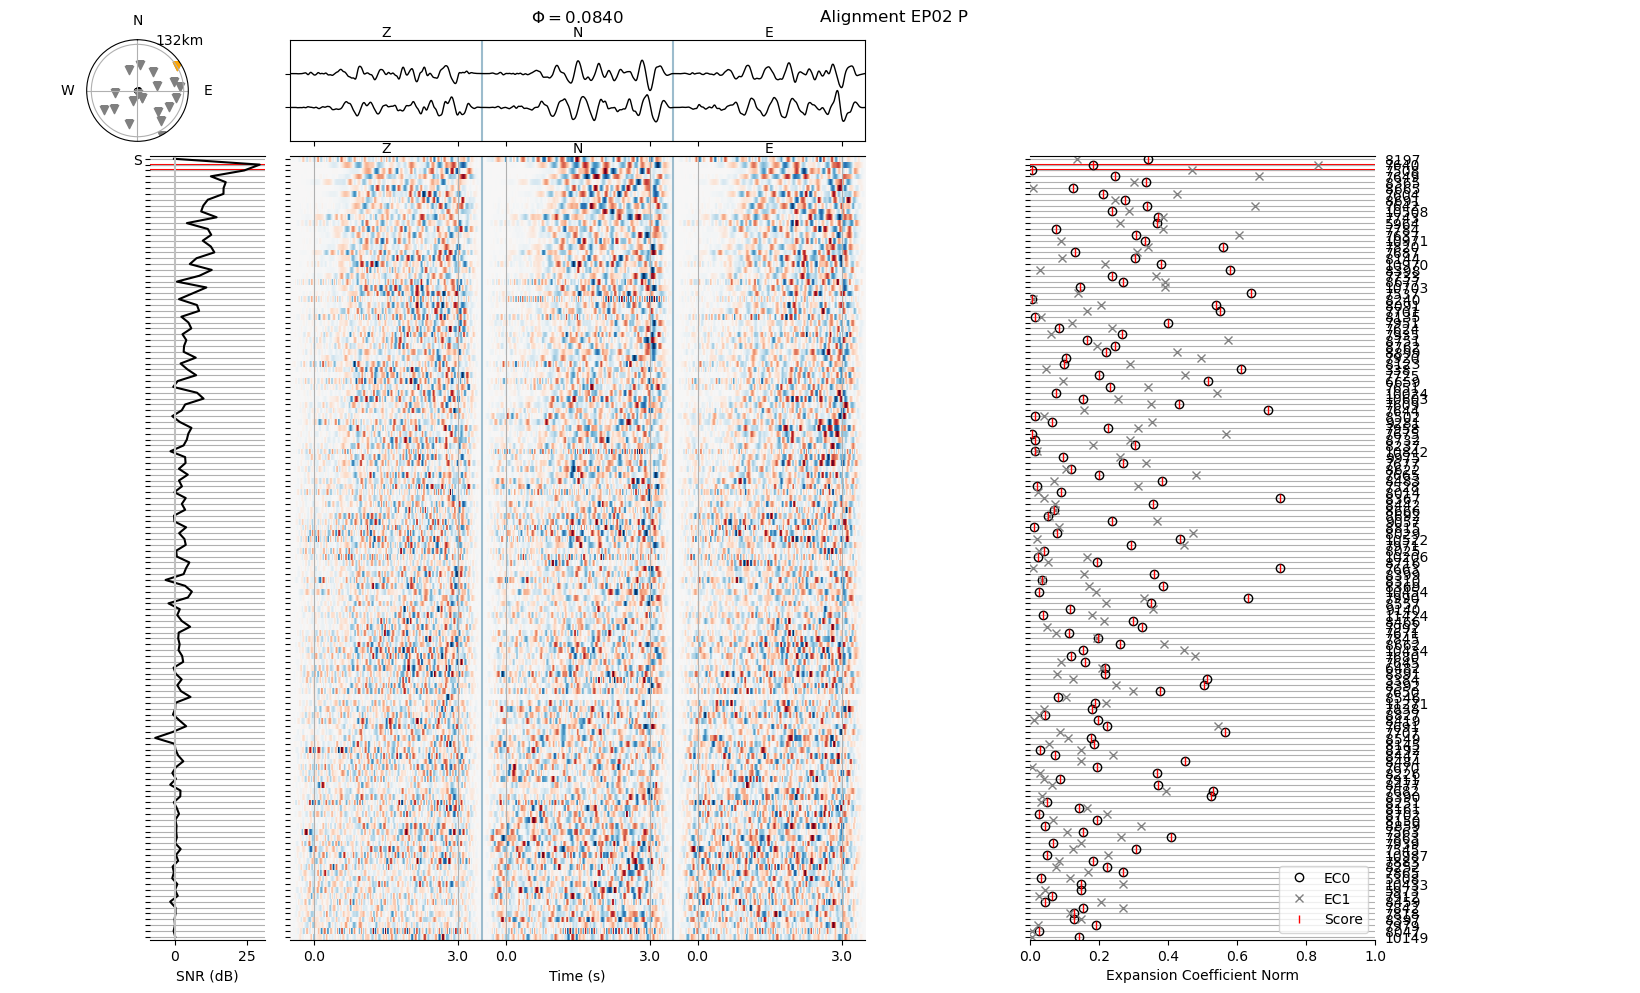

In [4]:
# Select a waveform header file
hdrf = core.file("waveform_header", "EP02", "P")
print("Header file is: ", hdrf)

# Store the old header to restore later
shutil.copy(hdrf, str(hdrf) + ".backup")

# Read the header
hdr = io.read_header(hdrf)

# Print the values we are interested in
print("Old header values:")
for key in ["phase_start", "phase_end", "highpass", "lowpass"]:
    print(f"{key}: {hdr[key]}")

# Modify header
hdr["phase_start"] = 0.0
hdr["phase_end"] = 3.0
hdr["highpass"] = 1
hdr["lowpass"] = 10.0

# Print the values we are interested in
print("New header values:")
for key in ["phase_start", "phase_end", "highpass", "lowpass"]:
    print(f"{key}: {hdr[key]}")

# Save it to file
hdr.to_file(hdrf, overwrite=True)

# Read the default config and plot again.
# We here use the python entry point of relmt plot-alignment
config = io.read_config("config.yaml")
main.plot_alignment_entry(
    Path("data") / "EP02_P-wvarr.npy",
    config,
    sort="magnitude",
    highlight_events=[7508, 7640],
    cc_method="none",
    confirm=False,  # For interactivity
)
print("Figure drawn")

# Restore old header
shutil.copy(str(hdrf) + ".backup", hdrf)
print("Old header restored.")


### Exclude traces by signal-noise-ratio
We now exclude all events that have a SNR smaller than 2 dB. Let us first set this value in the default header and see what this would mean for all waveforms in the data set.

In [5]:
hdrf = core.file("waveform_header")
print("Default header file is: ", hdrf)

# We set the minimum SNR in the default header file for all waveforms
hdr = io.read_header(hdrf)
hdr["min_signal_noise_ratio"] = 2.0
hdr.to_file(hdrf, overwrite=True)

# Read the default config and plot again.
# We here use the python entry point of relmt plot-alignment
config = io.read_config("config.yaml")


Default header file is:  data/default-hdr.yaml


Execute the next cell various times, to plot all available stations one after another. In a shell, this is equivalent to:

```shell
for wvf in data/*-wvarr
do
relmt plot-alignment $wvf --sort magnitude --highight 7508 7640 --cc none
done
```
The red vertical line in the SNR panel (left) indicates the threshold below which events will be excluded.

In [6]:

# Execute this cell to re-set the iterator over all waveforms.
wvfs = iter(sorted(Path("data").glob("*-wvarr.npy")))


Plotting from file:  data/BRC6_P-wvarr.npy


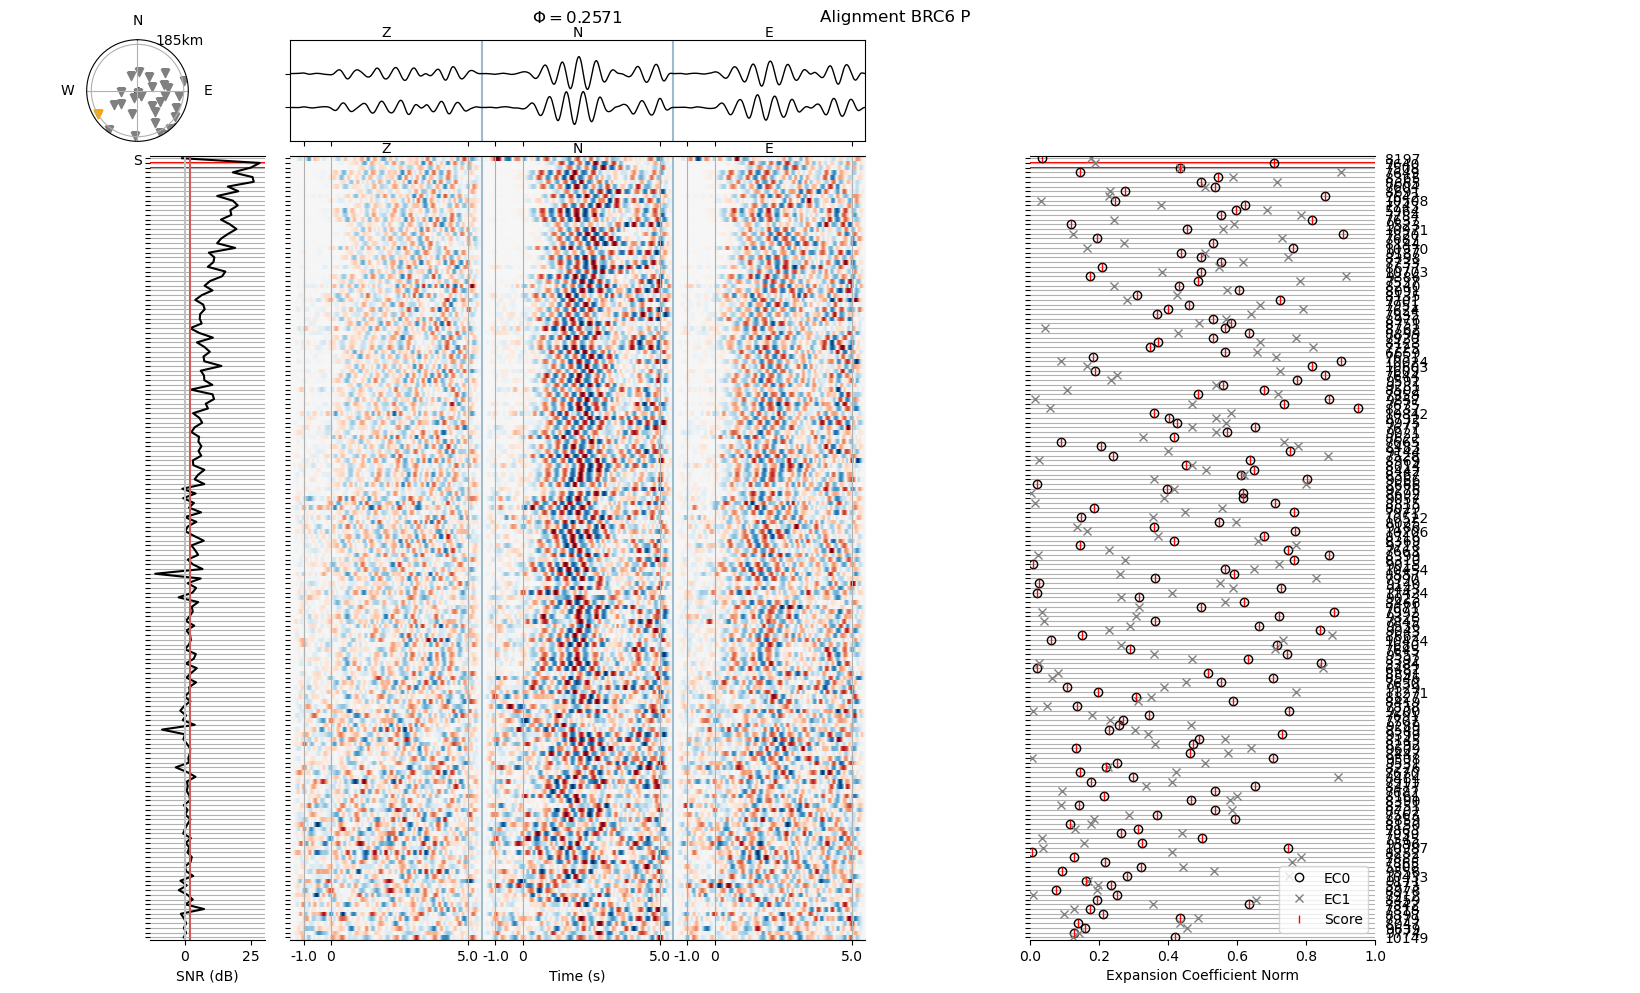

In [7]:
# Execute this cell repeatedly to look at all waveforms
try:
    wvf = next(wvfs)
except StopIteration:
    print("We reached the last file. Continue below.")

print("Plotting from file: ", wvf)
main.plot_alignment_entry(
    wvf,
    config,
    sort="magnitude",
    highlight_events=[7508, 7640],
    cc_method="none",
    confirm=False,
)


Let us exclude some data. Before we execute the command below, we set the logging output to "INFO" so that we get some feedback from *relMT* about how many seismic traces were removed.

In [8]:
conf = io.read_config("config.yaml")
conf["loglevel"] = "INFO"
conf.to_file("config.yaml", overwrite=True)

INFO     : Configuration written to: config.yaml


We use `relmt exclude` to exclude individual traces. The `--snr` flag means to exclude all data that have an SNR below the `min_singal_noise_ratio` value set in the waveform header file. The `--nodata` flag means to scan for traces that contain *NaN* values, or such that are all-zero (or all below the absolute `null_data` value set in the waveform header).

In [9]:
! relmt exclude --nodata --snr

INFO     : Reading excludes from: exclude.yaml


/projects/restricted/relMT/relmt/src/relMT/src/relmt/signal.py:571: RuntimeWarning: invalid value encountered in divide
  return dB(sms / nms)


INFO     : Excluding 80 invalid traces
INFO     : Excluding 4926 traces due to high SNR


## Aligning waveforms
To align the waveforms, let us first set the required parameters in the [configuration file](https://relmt.readthedocs.io/en/latest/formats/file_formats.html#configuration-file-config-yaml). These are in fact only `station_file` and `ncpu`. In a terminal based workflow, we would simply edit the configuration file `config.yaml` in a text editor. Here, we load the file, edit the `Config` object and save it back to file.

In [10]:
conf = io.read_config("config.yaml")
conf["ncpu"] = 20  # Depends on your hardware requirements
conf.to_file("config.yaml", overwrite=True)

INFO     : Configuration written to: config.yaml


We now align the waveforms. We here use only multi-channel cross-correlation (MCCC), which yields sample-accuracy. For this dataset, using 20 CPUs, alignment takes about 3 1/2 hours. A strategy to reduce the computational cost is to only allow certain event combinations. We will elaborate on this approach in Example 2.

In [11]:
! relmt align --mccc

INFO     : Aligning with MCCC


### Inspect pre-alignment results

Station wavetrains were attempted to be aligned to the sample. The alignment results were written to the `align1/` folder. Besides the waveform array files (ending in *-wvarr.npy*) and header files (ending in *-hdr.yaml*), we find cross-correlation and time shift tables (ending in *-dt_cc.txt* and *-cc.txt*).

In [12]:
! ls align1/

# Make a backup copy of all header files
for src in Path("align1").glob("*-hdr.yaml"):
    dst = str(src) + ".backup"
    shutil.copy(src, dst)

BRC6_P-cc.txt	  EP07_P-dt_cc.txt   EP15_P-hdr.yaml   EP25_S-wvarr.npy
BRC6_P-dt_cc.txt  EP07_P-hdr.yaml    EP15_P-wvarr.npy  EP27_P-cc.txt
BRC6_P-hdr.yaml   EP07_P-wvarr.npy   EP15_S-cc.txt     EP27_P-dt_cc.txt
BRC6_P-wvarr.npy  EP07_S-cc.txt      EP15_S-dt_cc.txt  EP27_P-hdr.yaml
BRC6_S-cc.txt	  EP07_S-dt_cc.txt   EP15_S-hdr.yaml   EP27_P-wvarr.npy
BRC6_S-dt_cc.txt  EP07_S-hdr.yaml    EP15_S-wvarr.npy  EP28_P-cc.txt
BRC6_S-hdr.yaml   EP07_S-wvarr.npy   EP16_P-cc.txt     EP28_P-dt_cc.txt
BRC6_S-wvarr.npy  EP08A_P-cc.txt     EP16_P-dt_cc.txt  EP28_P-hdr.yaml
CHE6_P-cc.txt	  EP08A_P-dt_cc.txt  EP16_P-hdr.yaml   EP28_P-wvarr.npy
CHE6_P-dt_cc.txt  EP08A_P-hdr.yaml   EP16_P-wvarr.npy  EP29_P-cc.txt
CHE6_P-hdr.yaml   EP08A_P-wvarr.npy  EP16_S-cc.txt     EP29_P-dt_cc.txt
CHE6_P-wvarr.npy  EP08_P-cc.txt      EP16_S-dt_cc.txt  EP29_P-hdr.yaml
CHE6_S-cc.txt	  EP08_P-dt_cc.txt   EP16_S-hdr.yaml   EP29_P-wvarr.npy
CHE6_S-dt_cc.txt  EP08_P-hdr.yaml    EP16_S-wvarr.npy  EP30_P-cc.txt
CHE6_S-hdr.yaml

Let's have a look how the alignment went. `relmt plot-alignment` now provides richer output, as cross-correlation values and time shifts have been computed. We will define the some additional processing parameters that will be displayed for acknowledgement while skimming through the waveforms.

In practice we would make an interactive alignment plot for each waveform and decide on waveform exclusion or refined parameters from looking at these plots.

```shell
for wvf in align1/*-wvarr.npy
do
relmt plot-alignment --highlight 7508 7640 --cc file $wvf
done
```

In [13]:
# Phases we will exclude, with reason
exclude_wvid = {
    "EP01_S": "Too few observations",
    "EP08_P": "too few observations",
    "EP08_S": "too few observations",
    "EP12_P": "too few observations",
    "EP12_S": "too few observations",
    "EP13_P": "a complex waveform at Pn/Pg crossing",
    "EP13_S": "a complex waveform at Sn/Sg crossing",
    "EP15_S": "a waveform too noisy and complex",
    "EP16_S": "a waveform too noisy",
    "EP18_S": "too few observations",
    "EP19_P": "too few and complex waveforms",
    "EP19_S": "too few and complex waveforms",
    "EP20_P": "too few and complex waveforms",
    "EP21_S": "too complex waveforms",
    "EP22_P": "too few observations and very distant",
    "EP24_P": "too few observations and very distant",
    "EP24_S": "too few observations and very distant",
    "EP25_P": "too complex observations and very distant",
    "EP27_P": "too few observations and very distant",
    "EP28_P": "too complex observations and very distant",
    "EP29_P": "too complex observations and very distant",
    "ICE6_P": "too few observations",
    "ICE6_S": "too few observations",
    "ISH6_P": "too few, distant and complex observations",
    "LAN6_P": "too complex observations, very distant",
    "LAN6_S": "too few observations, very distant",
    "P146_P": "too few observations",
    "P146_S": "too few observations",
}

# Time windows we will adapt
new_phase_start_end = {
    "BRC6_P": (-0.5, 3.5),
    "BRC6_S": (0.5, 4),
    "CHE6_P": (0, 3),
    "CHE6_S": (-0.5, 3.5),
    "EP02_S": (0.5, 5.0),
    "EP03_P": (0, 4),
    "EP03_S": (0.5, 5),
    "EP04_P": (0, 4),
    "EP04_S": (-0.5, 4),
    "EP05_P": (-1, 4),
    "EP05_S": (-1, 4),
    "EP06_S": (2, 5.5),
    "EP07_P": (-1, 4.0),
    "EP09_P": (-1.5, 2),
    "EP09_S": (-1, 4),
    "EP10_S": (-1, 4),
    "EP14_P": (-1, 4),
    "EP14_P": (0, 5),
    "EP16_P": (-1.5, 3.5),
    "EP21_P": (-1.5, 3.5),
    "P116_P": (-1, 4.0),
}

# Expansion coefficient norm exclusion criterion we will apply
ecn_threshold = {
    "BRC6_P": 0.8,
    "BRC6_S": 0.7,
    "CHE6_P": 0.5,
    "CHE6_S": 0.7,
    "EP02_P": 0.7,
    "EP03_P": 0.6,
    "EP04_P": 0.6,
    "EP06_P": 0.6,
    "EP06_S": 0.5,
    "EP07_P": 0.5,
    "EP07_S": 0.5,
    "EP08A_P": 0.6,
    "EP09_P": 0.5,
    "EP10_P": 0.8,
    "EP11_P": 0.55,
    "EP11_P": 0.6,
    "EP14_P": 0.5,
    "EP14_S": 0.6,
    "EP14_P": 0.81,
    "EP16_P": 0.7,
    "EP18_P": 0.7,
    "EP21_P": 0.7,
    "EP30_P": 0.8,
    "P116_P": 0.6,
    "P116_S": 0.6,
    "P236_P": 0.6,
    "P236_S": 0.6,
    "SUM6_P": 0.6,
}

### Quality control of the alignment

We will next plot the waveforms and quality metrics as they were returned from the first alignment iteration, one after another. Additionally, we will provide some rationale for why a waveform had been excluded, how a phase window was changed, or which threshold for exclusion of individual events was applied.

We will load the exclude file and append the excluded waveform IDs to the `waveform` list. In practice, this could be done by editing the `exclude.yaml` file.

In [14]:
# Iterator over all waveforms
wvfs = iter(sorted(Path("align1").glob("*-wvarr.npy")))

config = io.read_config("config.yaml")
config["loglevel"] = "WARNING"  # Don't clutter print output below
exclude = io.read_exclude_file("exclude.yaml")

Execute the next cell various times to repeat plotting the waveforms. When you loose interest, execute the cell following after to fast-foward application of all header values and exclusion entries.

Plotting from file:  align1/BRC6_P-wvarr.npy
We will set a new phase window, from -0.5 to 3.5 seconds
Waveforms below an ECN of 0.8 appear too noisy or ambiguous and will be excluded
Before and after editing the header:


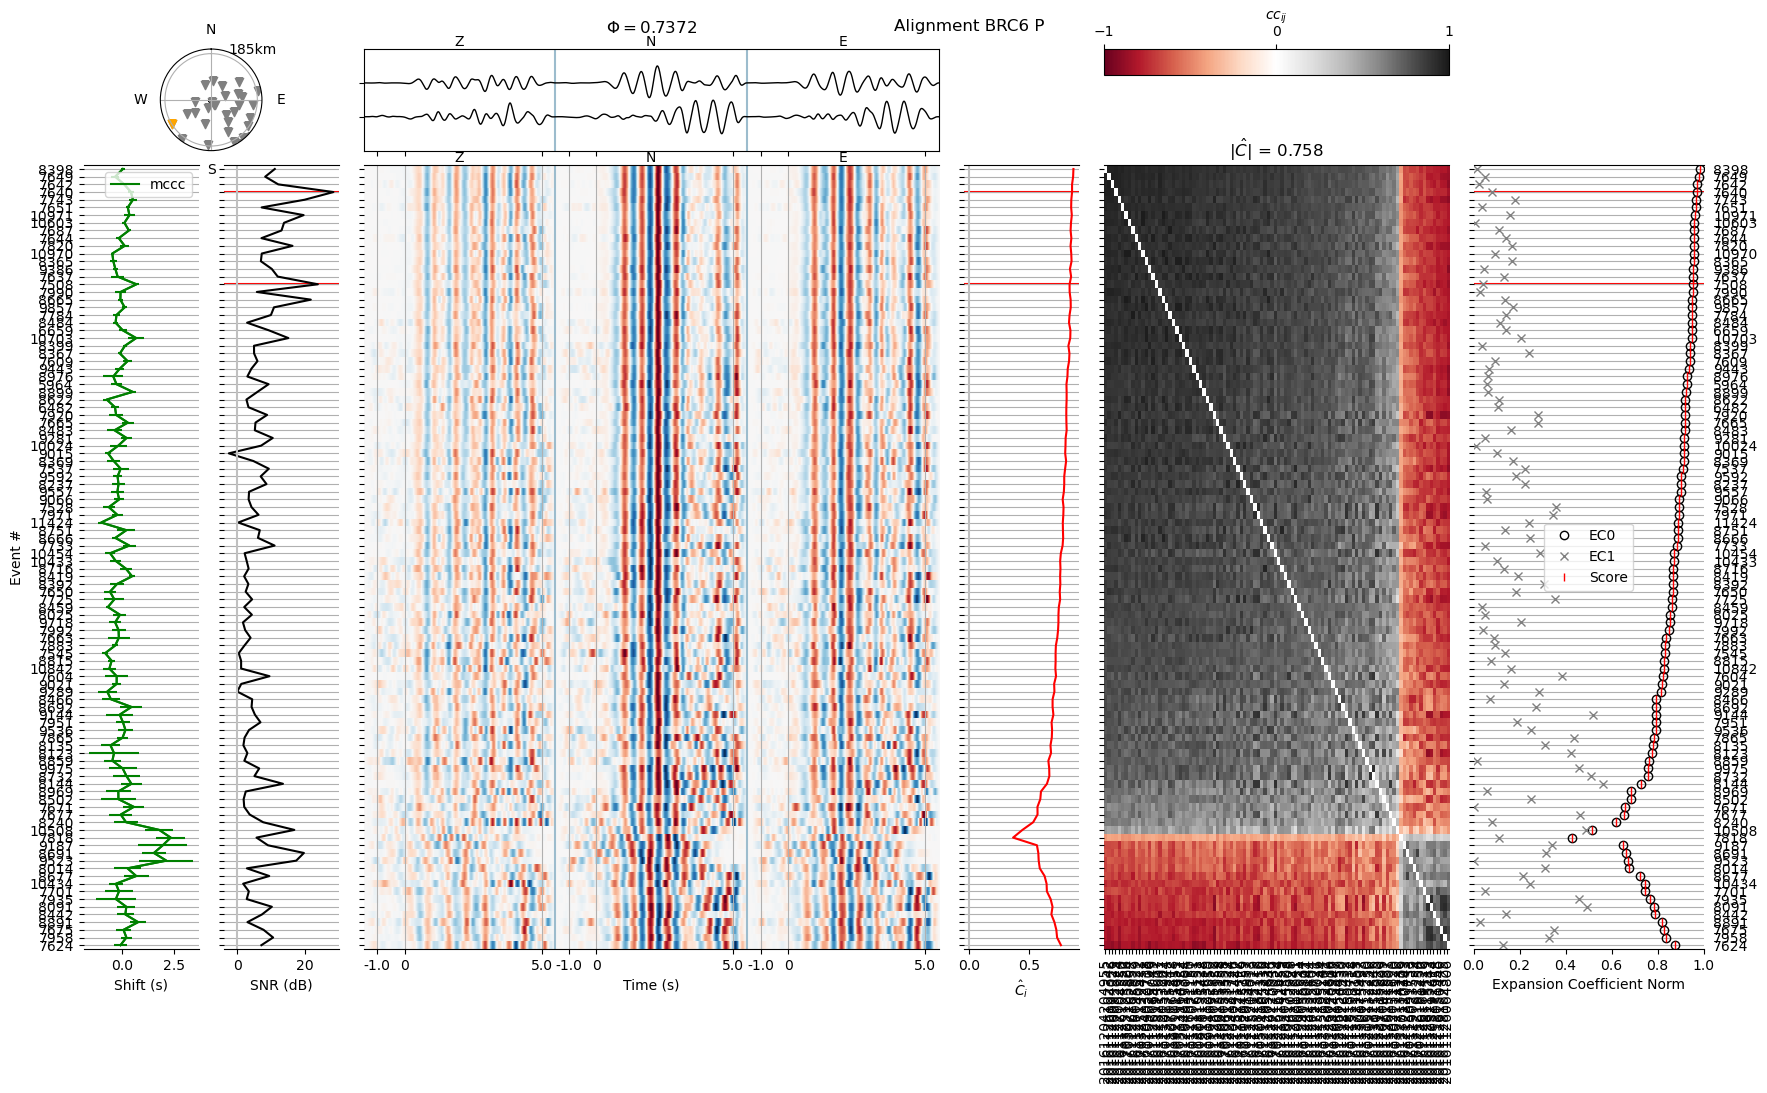

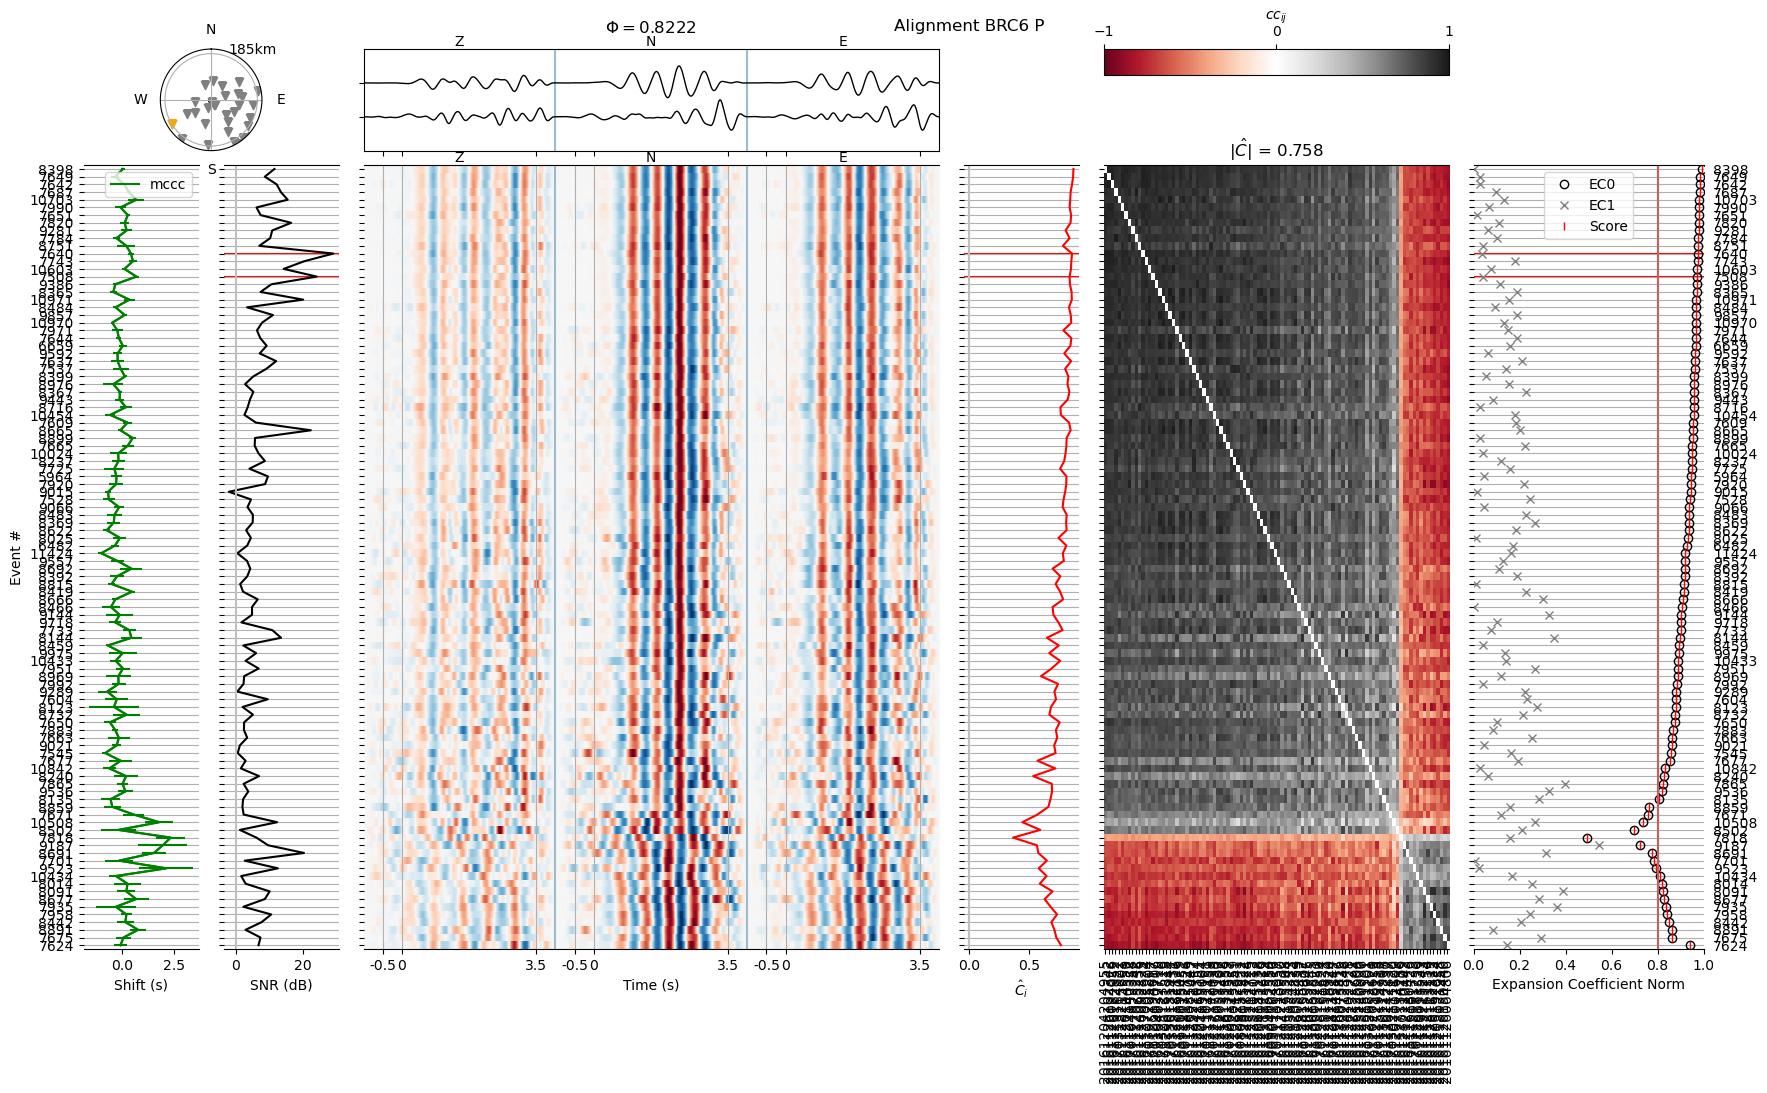

In [15]:

wvf = next(wvfs)

print("Plotting from file: ", wvf)

# Identify waveid from filename. Open corresponding header
wvid = wvf.stem.split("-wvarr")[0]
sta, pha = core.split_waveid(wvid)
hdrf = core.file("waveform_header", sta, pha, 1)
hdr = io.read_header(hdrf)

after = "and after "
if wvid in exclude_wvid:
    print(f"This waveform ({wvid}) should be excluded, because of {exclude_wvid[wvid]}")
    after = ""
    
    # Only append if not already present
    if wvid not in exclude["waveform"]:
        exclude["waveform"] += [wvid]

if wvid in new_phase_start_end:
    start, end= new_phase_start_end[wvid]
    print(f"We will set a new phase window, from {start} to {end} seconds")
    hdr["phase_start"] = start
    hdr["phase_end"] = end

if wvid in ecn_threshold:
    ecn = ecn_threshold[wvid]
    print(f"Waveforms below an ECN of {ecn} appear too noisy or ambiguous and will be excluded")
    hdr["min_expansion_coefficient_norm"] = ecn

print(f"Before {after}editing the header:")
main.plot_alignment_entry(
    wvf,
    config,
    highlight_events=[7508, 7640],
    cc_method="file",
    confirm=False,
)

hdr.to_file(hdrf, True)

if wvid not in exclude_wvid:
    main.plot_alignment_entry(
        wvf,
        config,
        highlight_events=[7508, 7640],
        cc_method="file",
        confirm=False,
    )

In [16]:
# Go through the rest of the iterator and apply all changes
for wvf in wvfs:
    wvid = wvf.stem.split("-wvarr")[0]
    sta, pha = core.split_waveid(wvid)
    hdrf = core.file("waveform_header", sta, pha, 1)
    hdr = io.read_header(hdrf)

    if wvid in exclude_wvid and wvid not in exclude["waveform"]:
        exclude["waveform"] += [wvid]

    if wvid in new_phase_start_end:
        start, end= new_phase_start_end[wvid]
        hdr["phase_start"] = start
        hdr["phase_end"] = end

    if wvid in ecn_threshold:
        ecn = ecn_threshold[wvid]
        hdr["min_expansion_coefficient_norm"] = ecn

    hdr.to_file(hdrf, True)

io.save_yaml("exclude.yaml", exclude)

# Set log level back to Info
config["loglevel"] = "INFO"
config.to_file("config.yaml", True)


INFO     : Configuration written to: config.yaml


### Add bad traces to the exlusion file

We will once more add traces to the exclusion file. This time, we exclude based on the expansion coefficient norm, which is the fraction by which each seismogram is represented by the principal seismogram (seismogram*s* for *S* waves), using the `--ecn` flag. We also specify, that we read from alignment iteration 1 using the `-a 1` flag.

In [17]:
! relmt exclude -a 1 --ecn

INFO     : Reading excludes from: exclude.yaml
INFO     : Excluding 559 traces due to low ECN


## Re-align the wavefoms

We are now readu to re-align the waveforms. As there might be cases of cycle-skipping, we apply both the MCCC and the PCA method. This is the default. We are reading from the first alignment iteration and must therefore parse the `-a 1` flag. This command runs a while...

In [18]:
! relmt align -a 1

INFO     : Aligning with MCCC and PCA


## Confirm that all waveforms are well-aligned
We go once more through all station waveforms and confirm that they are well aligned. Some event waveforms are still too poor to yield a reliable amplitude estimate.

We exclude those by defining a global *minimum expansion coefficient norm* threshold of *0.8* in the default headers. Event waveforms that have a lower value will be excluded from further processing. Some station waveforms exhibit unclear waveforms or show signs of cycle skipping that cannot be resolved. We exclude those manually from further processing.

In [19]:
exclude_wvid = {
    "BRC6_S": "unresolvable cycle skipping",
    "EP02_S": "unresolvable cycle skipping",
    "EP15_S": "no clear waveform pattern",
    "EP16_S": "no clear waveform pattern",
    "EP18_S": "unclear and few waveforms",
    "EP19_S": "no clear waveform pattern",
    "EP21_S": "no clear waveform pattern",
    "EP25_P": "no clear waveform pattern",
    "ISH6_P": "no waveform in window",
    "LAN6_P": "unresolvable cycle skipping",
    "P146_P": "too poor data",
    "P146_S": "too poor data",
}

# Set one trace exclusion criterion for all files
core.Header(min_expansion_coefficient_norm=0.8).to_file("align2/default-hdr.yaml", True)

INFO     : Configuration written to: align2/default-hdr.yaml


In [20]:
# Iterator over all waveforms
wvfs = iter(sorted(Path("align2").glob("*-wvarr.npy")))

Plotting from file:  align2/BRC6_P-wvarr.npy


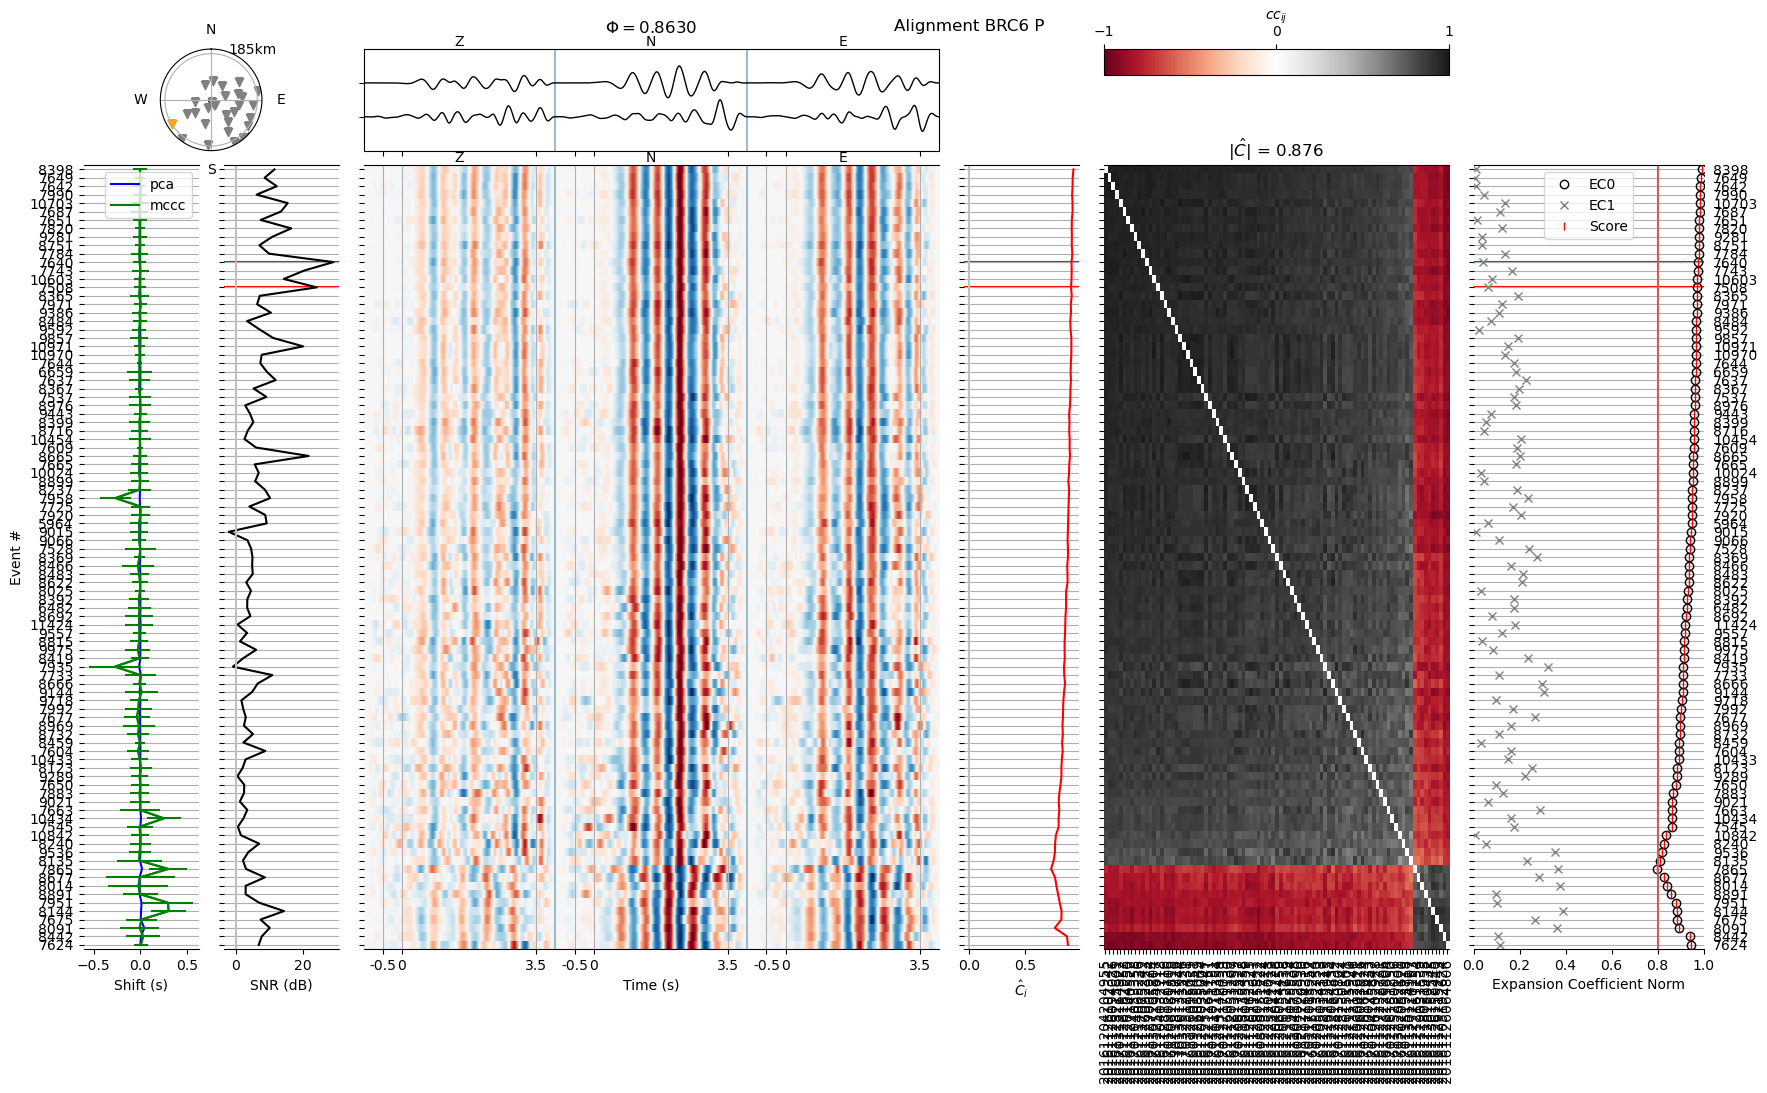

In [21]:
# Go through the stations
try:
    wvf = next(wvfs)
    wvid = wvf.stem.split("-wvarr")[0]

    print("Plotting from file: ", wvf)

    if wvid in exclude_wvid:
        print(f"! Excluding waveform, due to {exclude_wvid[wvid]}!")

    main.plot_alignment_entry(
        wvf,
        config,
        sort="pci",
        highlight_events=[7508, 7640],
        cc_method="file",
        confirm=False,
    )

except StopIteration:
    print("Went through all files.")
    print("Please continue below or execute previous cell to restart.")

We now discard the waveforms we deemed unreliable and exclude the waveforms that do not fulfill the `ecn > 0.8` quality criterion.

In [22]:
# Append excluded waveforms to exclusion file
exclude = io.read_exclude_file("exclude.yaml")
exclude["waveform"] = sorted(set(exclude["waveform"]).union(exclude_wvid.keys()))
io.save_yaml("exclude.yaml", exclude)

In [23]:
! relmt exclude -a 2 --ecn

INFO     : Reading excludes from: exclude.yaml
INFO     : Excluding 1454 traces due to low ECN


## Conclusion

In this example we aligned *P* and *S* waveforms in two steps. The aligned wave are stored in the `align2/` subfolder. We can go ahead an measure relative amplitudes on them.